In [1]:
from imutils.video import VideoStream
from imutils import face_utils
import datetime
import argparse
import imutils
import time
import dlib
import cv2
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import *
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import relu
from keras.initializers import RandomNormal
from keras.applications import *
import keras.backend as K
import numpy as np 
import os
import matplotlib.pyplot as plt 
import cv2
import scipy.ndimage as ndimage
import time
import dlib
from PIL import Image
from skimage import io
import matplotlib.pyplot as plt

from FCN8s_keras import FCN
model = FCN()
model.load_weights("Keras_FCN8s_face_seg_YuvalNirkin.h5")
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [1]:
import cv2
cam = cv2.VideoCapture(0)
for i in range(10):
    return_value, image = cam.read()
    cv2.imwrite('opencv'+str(i)+'.png', image)

cam.release()
cv2.destroyAllWindows()

In [2]:
def detect_faces(image):

    # Create a face detector
    face_detector = dlib.get_frontal_face_detector()

    # Run detector and get bounding boxes of the faces on image.
    detected_faces = face_detector(image, 1)
    face_frames = [(x.left(), x.top(),
                    x.right(), x.bottom()) for x in detected_faces]

    return face_frames

def vgg_preprocess(im):
    im = cv2.resize(im, (500, 500))
    in_ = np.array(im, dtype=np.float32)
    in_ = in_[:,:,::-1]
    in_ -= np.array((104.00698793,116.66876762,122.67891434))
    in_ = in_[np.newaxis,:]
    return in_
  
def auto_downscaling(im):
    w = im.shape[1]
    h = im.shape[0]
    while w*h >= 700*700:
        im = cv2.resize(im, (0,0), fx=0.5, fy=0.5)
        w = im.shape[1]
        h = im.shape[0]
    return im


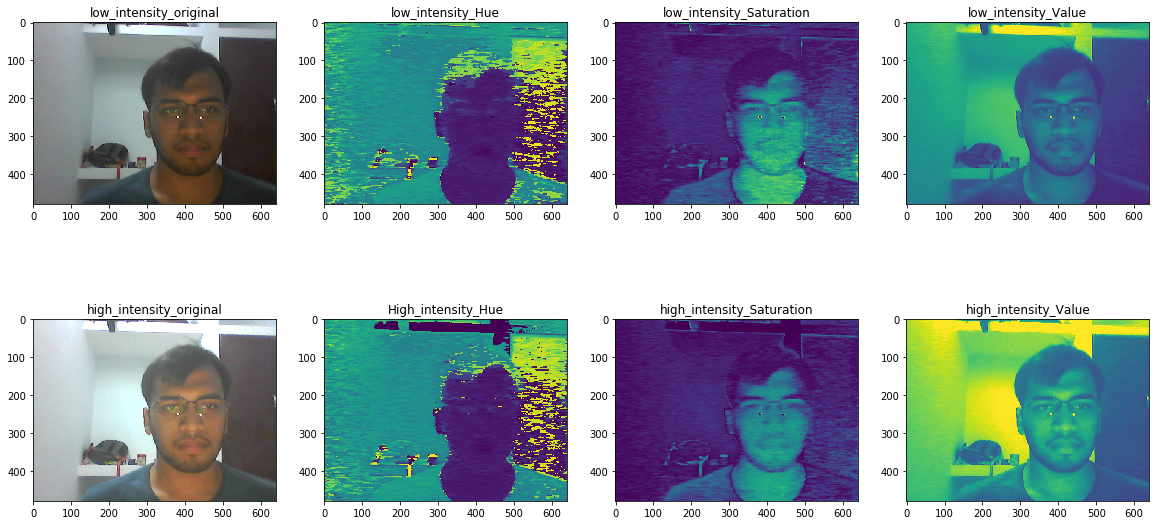

In [52]:
orig1 = cv2.cvtColor(cv2.imread('opencv3.png'),cv2.COLOR_BGR2RGB)
orig2 = cv2.cvtColor(cv2.imread('opencv9.png'),cv2.COLOR_BGR2RGB)
test1 = cv2.cvtColor(cv2.imread('opencv3.png'), cv2.COLOR_BGR2HSV)
test2 = cv2.cvtColor(cv2.imread('opencv9.png'), cv2.COLOR_BGR2HSV)
plt.figure(figsize=(20,10))
ax = plt.subplot(241)
ax.imshow(orig1),ax.set_title('low_intensity_original')
ax = plt.subplot(242)
ax.imshow(test1[:,:,0]),ax.set_title('low_intensity_Hue')
ax = plt.subplot(243)
ax.imshow(test1[:,:,1]),ax.set_title('low_intensity_Saturation')
ax = plt.subplot(244)
ax.imshow(test1[:,:,2]),ax.set_title('low_intensity_Value')
ax = plt.subplot(245)
ax.imshow(orig2),ax.set_title('high_intensity_original')
ax = plt.subplot(246)
ax.imshow(test2[:,:,0]),ax.set_title('High_intensity_Hue')
ax = plt.subplot(247)
ax.imshow(test2[:,:,1]),ax.set_title('high_intensity_Saturation')
ax = plt.subplot(248)
ax.imshow(test2[:,:,2]),ax.set_title('high_intensity_Value')

plt.show()

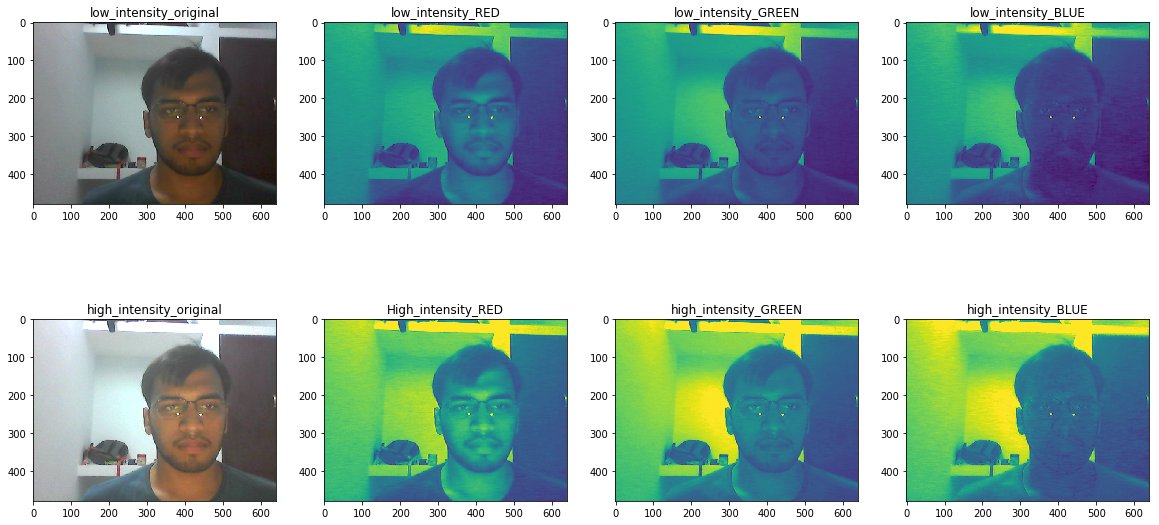

In [53]:
orig1 = cv2.cvtColor(cv2.imread('opencv3.png'),cv2.COLOR_BGR2RGB)
orig2 = cv2.cvtColor(cv2.imread('opencv9.png'),cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,10))
ax = plt.subplot(241)
ax.imshow(orig1),ax.set_title('low_intensity_original')
ax = plt.subplot(242)
ax.imshow(orig1[:,:,0]),ax.set_title('low_intensity_RED')
ax = plt.subplot(243)
ax.imshow(orig1[:,:,1]),ax.set_title('low_intensity_GREEN')
ax = plt.subplot(244)
ax.imshow(orig1[:,:,2]),ax.set_title('low_intensity_BLUE')
ax = plt.subplot(245)
ax.imshow(orig2),ax.set_title('high_intensity_original')
ax = plt.subplot(246)
ax.imshow(orig2[:,:,0]),ax.set_title('High_intensity_RED')
ax = plt.subplot(247)
ax.imshow(orig2[:,:,1]),ax.set_title('high_intensity_GREEN')
ax = plt.subplot(248)
ax.imshow(orig2[:,:,2]),ax.set_title('high_intensity_BLUE')

plt.show()

In [64]:
lower = np.array([0, 48, 80], dtype = "uint8")
upper = np.array([20, 255, 255], dtype = "uint8")
frame = imutils.resize(orig2, width = 400)
converted = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)
skinMask = cv2.inRange(converted, lower, upper)
#plt.imsave('skinMask.png',skinMask)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
skinMask = cv2.erode(skinMask, kernel, iterations = 2)
skinMask = cv2.dilate(skinMask, kernel, iterations = 2)
skinMask = cv2.GaussianBlur(skinMask, (3, 3), 0)
#plt.imsave('skinMask2.png',skinMask)
skin = cv2.bitwise_and(frame, frame, mask = skinMask)
plt.imsave('skinMask.png',skin)

[(291, 167, 513, 390)]


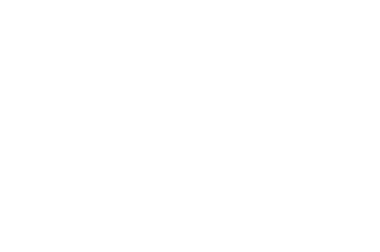

In [65]:
# Load image
img_path = 'opencv9.png'
image = io.imread(img_path)


# Detect faces
detected_faces = detect_faces(image)
print(detected_faces)

# Crop faces and plot
for n, face_rect in enumerate(detected_faces):
    face = Image.fromarray(image).crop(face_rect)
    plt.subplot(1, len(detected_faces), n+1)
    plt.axis('off')
    #plt.imshow(face)
    face.save('2.jpg') 
   

In [66]:
im = cv2.cvtColor(cv2.imread('2.jpg'), cv2.COLOR_BGR2RGB)
im = auto_downscaling(im)
inp_im = vgg_preprocess(im)
out = model.predict([inp_im])
out_resized = cv2.resize(np.squeeze(out), (im.shape[1],im.shape[0]))
out_resized_clipped = np.clip(out_resized.argmax(axis=2), 0, 1).astype(np.float64)
mask = cv2.GaussianBlur(out_resized_clipped, (7,7), 6)
plt.imsave('face_mask.jpg',(mask[:,:,np.newaxis]*im.astype(np.float64)).astype(np.uint8))
plt.imsave('binary_mask.jpg',out_resized_clipped, cmap='gray')


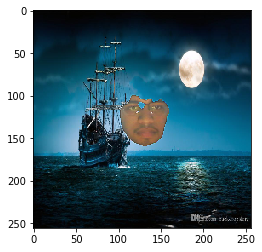

In [67]:
import cv2
import matplotlib.pyplot as plt
BLACK = [0,0,0]
WHITE = [255,255,255]
mask = plt.imread('binary_mask.jpg')
face_mask = plt.imread('face_mask.jpg')
backg = plt.imread('wall.jpg')
backg = cv2.resize(backg,(256,256))
mask = cv2.resize(mask,(64,64))
face_mask = cv2.resize(face_mask,(64,64))
mask = cv2.bitwise_not(mask)
leftDiff = 96
rightDiff = 96
downDiff = 96
upDiff = 96
mask = cv2.copyMakeBorder(mask,upDiff,downDiff, leftDiff,rightDiff,cv2.BORDER_CONSTANT, value=WHITE )
face_mask = cv2.copyMakeBorder(face_mask,upDiff,downDiff, leftDiff,rightDiff,cv2.BORDER_CONSTANT, value=BLACK )
img3 = cv2.bitwise_and(backg,mask)
img5 = cv2.add(face_mask,img3)
plt.imshow(img5)